In [1]:
import sys
import math
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
#Extract
#Note. Data is taken with an Iphone attach to the right side of the person
#      with tape at the specified body part (filename). Except for the 
#      pocket data, which we just put the Iphone in the right pocket.
ankle = pd.read_csv('data/ankle.csv', sep = ', ', engine = 'python')
arm = pd.read_csv('data/arm.csv', sep = ', ', engine = 'python')
pocket = pd.read_csv('data/pocket.csv', sep = ', ', engine = 'python')

ankle_2 = pd.read_csv('data/ankle_2.csv', sep = ', ', engine = 'python')
arm_2 = pd.read_csv('data/arm_2.csv', sep = ', ', engine = 'python')
pocket_2 = pd.read_csv('data/pocket_2.csv', sep = ', ', engine = 'python')

In [3]:
#Taking a look at the data that the app provided for us
ankle

,SamplingTime,AccelerationX,AccelerationY,AccelerationZ,GyroX,GyroY,GyroZ,MagneticFieldX,MagneticFieldY,MagneticFieldZ
0,1.648228e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,",",NaN
1,1.648228e+09,-0.167893,-9.863812,0.514005,-0.012441,0.014840,0.002449,95.228271,-2.990036,68.927826
2,1.648228e+09,-0.242563,-9.800515,0.580295,-0.014517,0.016564,-0.009653,95.231949,-2.791901,68.744110
3,1.648228e+09,-0.028132,-9.776124,0.503830,-0.020387,0.019050,-0.012963,95.427536,-2.764954,69.003922
4,1.648228e+09,-0.072574,-9.769690,0.563086,-0.023714,0.012049,-0.011384,95.545135,-3.027954,68.732559
...,...,...,...,...,...,...,...,...,...,...
1016,1.648228e+09,-0.714220,-9.651027,1.434725,-0.028156,0.020871,-0.025749,104.346664,-62.079697,15.019745
1017,1.648228e+09,-0.485275,-9.707291,1.547253,-0.031387,-0.006674,-0.023705,104.298630,-62.024231,15.074478
1018,1.648228e+09,-0.628628,-9.641151,1.423503,-0.031050,-0.001378,-0.011456,104.465439,-62.100433,15.213181
1019,1.648228e+09,-0.595707,-9.716419,1.378611,-0.027181,-0.009854,-0.024399,104.469833,-62.153793,14.987198


In [4]:
datalist = [ankle, arm, pocket, ankle_2, arm_2, pocket_2]

#Transform
for df in datalist:
    #After grabing start and end time, drop nan data
    start = df['SamplingTime'].iloc[0]
    end = df['SamplingTime'].iloc[-1]
    df.dropna(axis = 0, inplace = True)
    
    #Drop data
    start += 0.5
    end -= 0.5
    df.drop(df[df['SamplingTime'] < start].index, inplace = True)
    df.drop(df[df['SamplingTime'] > end].index, inplace = True)
    
    #Find acceleration
    df['Acceleration'] = ((df['AccelerationX']**2+
                          df['AccelerationY']**2+
                          df['AccelerationZ']**2)**(1/2))
    # df['Acceleration'] -= 9.81
    
    #SamplingTime to datetime
    df['Date'] = pd.to_datetime(df['SamplingTime'], unit='s')
    
    #Time duration
    df['Time'] = df['SamplingTime']-start

ankle[['SamplingTime', 'AccelerationX','AccelerationY','AccelerationZ','Acceleration','Date','Time']]

,SamplingTime,AccelerationX,AccelerationY,AccelerationZ,Acceleration,Date,Time
16,1.648228e+09,-1.063325,-9.889998,0.299874,9.951515,2022-03-25 17:00:44.171636224,0.033386
17,1.648228e+09,-1.975516,-10.418967,0.315436,10.609290,2022-03-25 17:00:44.204907008,0.066657
18,1.648228e+09,-1.928529,-10.704176,0.581342,10.892041,2022-03-25 17:00:44.238234880,0.099985
19,1.648228e+09,-1.035642,-11.363330,1.108066,11.464102,2022-03-25 17:00:44.271584000,0.133334
20,1.648228e+09,-0.474202,-11.050288,1.424400,11.151800,2022-03-25 17:00:44.304971008,0.166721
...,...,...,...,...,...,...,...
1000,1.648228e+09,-0.857723,-9.717616,1.439813,9.861076,2022-03-25 17:01:16.971809024,32.833559
1001,1.648228e+09,-0.792032,-9.677213,1.581669,9.837553,2022-03-25 17:01:17.005142016,32.866892
1002,1.648228e+09,-0.675015,-9.643246,1.563863,9.792523,2022-03-25 17:01:17.038525952,32.900276
1003,1.648228e+09,-0.843956,-9.630227,1.451036,9.775430,2022-03-25 17:01:17.071808000,32.933558


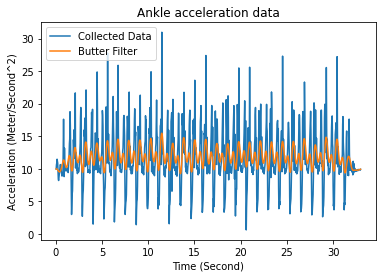

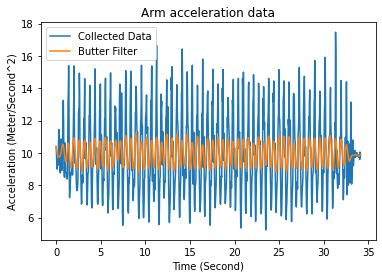

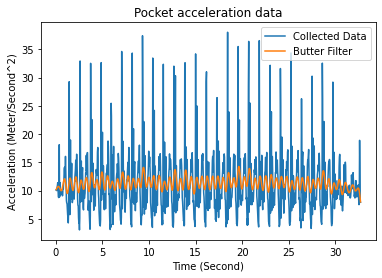

In [5]:
#Ankle
b, a = signal.butter(3, 0.10, btype='lowpass', analog=False)
ankle['Filtered'] = signal.filtfilt(b, a, ankle['Acceleration'])
plt.plot(ankle['Time'], ankle['Acceleration'])
plt.plot(ankle['Time'], ankle['Filtered'])
plt.title('Ankle acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

#Arm
arm['Filtered'] = signal.filtfilt(b, a, arm['Acceleration'])
plt.plot(arm['Time'], arm['Acceleration'])
plt.plot(arm['Time'], arm['Filtered'])
plt.title('Arm acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

#Pocket
pocket['Filtered'] = signal.filtfilt(b, a, pocket['Acceleration'])
plt.plot(pocket['Time'], pocket['Acceleration'])
plt.plot(pocket['Time'], pocket['Filtered'])
plt.title('Pocket acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

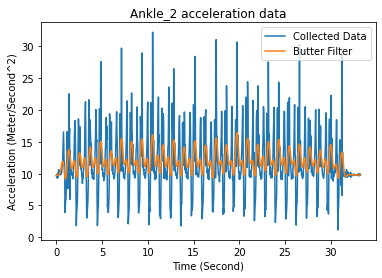

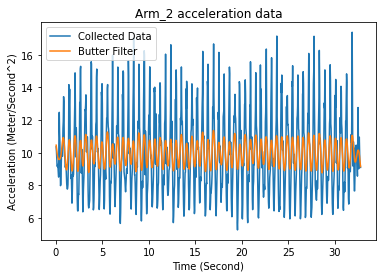

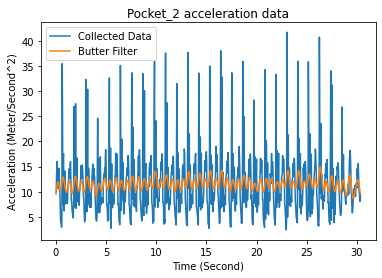

In [6]:
#Ankle2
ankle_2['Filtered'] = signal.filtfilt(b, a, ankle_2['Acceleration'])
plt.plot(ankle_2['Time'], ankle_2['Acceleration'])
plt.plot(ankle_2['Time'], ankle_2['Filtered'])
plt.title('Ankle_2 acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

#Arm2
arm_2['Filtered'] = signal.filtfilt(b, a, arm_2['Acceleration'])
plt.plot(arm_2['Time'], arm_2['Acceleration'])
plt.plot(arm_2['Time'], arm_2['Filtered'])
plt.title('Arm_2 acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

#Pocket2
pocket_2['Filtered'] = signal.filtfilt(b, a, pocket_2['Acceleration'])
plt.plot(pocket_2['Time'], pocket_2['Acceleration'])
plt.plot(pocket_2['Time'], pocket_2['Filtered'])
plt.title('Pocket_2 acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

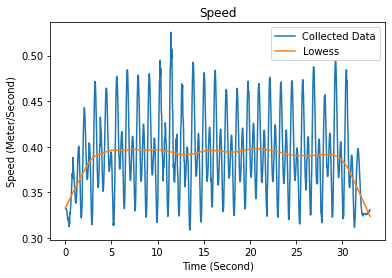

In [7]:
#Approximate speed using acceleration(after filter) * time
ankle['PreviousTime'] = ankle['Time'].shift(1)
ankle = ankle.fillna(0.0)
ankle['Speed'] = ankle['Filtered'] * (ankle['Time'] - ankle['PreviousTime'])
plt.plot(ankle['Time'], ankle['Speed'])

#Lowess line
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(ankle['Speed'], ankle['Time'], frac=0.15)
plt.plot(filtered[:, 0], filtered[:, 1])

plt.title('Speed')
plt.xlabel('Time (Second)')
plt.ylabel('Speed (Meter/Second)')
plt.legend(['Collected Data', 'Lowess'])
plt.show()
#As you can see Speed is very noise by itself. Speed should plateau
#once we hit our top walking speed. Lowess line helped us filter out noise and
#give us a more acurrate reading

In [8]:
# #Displacement
# ankle['Position'] = ankle['Speed'] * (ankle['Time'] - ankle['PreviousTime'])
# plt.plot(ankle['Time'], ankle['Position'])

# plt.title('Displacement')
# plt.xlabel('Time (Second)')
# plt.ylabel('Position (Meter)')
# plt.legend(['Collected Data'])
# plt.show()
# #Displacement should be going up and down like a wave, since when you
# #lift your right leg (it should increase in displacement), and when right your leg
# #is grounded because the other leg is lifted (there should be a decrease in displacement)

In [9]:
# #This whole cell needs work
# #fourier transform
# from scipy import fft

# #tried to correct Acceleration to ignore gravity
# ankle['Acceleration'] = ((ankle['AccelerationX']**2+
#                        (ankle['AccelerationY']+9.81)**2+
#                        ankle['AccelerationZ']**2)**(1/2))

# b, a = signal.butter(3, 0.10, btype='lowpass', analog=False)
# ankle['Filtered'] = signal.filtfilt(b, a, ankle['Acceleration'])
# FFT = np.abs(fft.fft(ankle['Filtered'].to_numpy()))
# t = df['Time'].iloc[0]
# freq = fft.fftfreq(len(FFT), 1/t)
# plt.plot(freq, FFT)
# plt.title('Fast Fourier Transform')
# plt.show()
# print()

In [10]:
#backward and foward
#Note. Data taken on a different day, taping iphone on ankle 
forward = pd.read_csv('data/forward.csv', sep = ', ', engine = 'python')
backward = pd.read_csv('data/backward.csv', sep = ', ', engine = 'python')
male = pd.read_csv('data/male.csv', sep = ', ', engine = 'python')
female = pd.read_csv('data/female.csv', sep = ', ', engine = 'python')

In [11]:
datalist = [forward, backward, male, female]

#Transform
for df in datalist:
    #After grabing start and end time, drop nan data
    start = df['SamplingTime'].iloc[0]
    end = df['SamplingTime'].iloc[-1]
    df.dropna(axis = 0, inplace = True)
    
    #Drop data
    start += 0.5
    end -= 0.5
    df.drop(df[df['SamplingTime'] < start].index, inplace = True)
    df.drop(df[df['SamplingTime'] > end].index, inplace = True)
    
    #Find acceleration
    df['Acceleration'] = ((df['AccelerationX']**2+
                          df['AccelerationY']**2+
                          df['AccelerationZ']**2)**(1/2))
    #df['Acceleration'] -= 9.81
    
    #SamplingTime to datetime
    df['Date'] = pd.to_datetime(df['SamplingTime'], unit='s')
    
    #Time duration
    df['Time'] = df['SamplingTime']-start

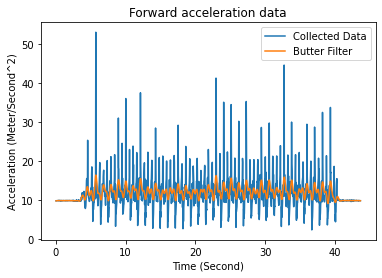

In [12]:
#Forward
b, a = signal.butter(3, 0.10, btype='lowpass', analog=False)
forward['Filtered'] = signal.filtfilt(b, a, forward['Acceleration'])
plt.plot(forward['Time'], forward['Acceleration'])
plt.plot(forward['Time'], forward['Filtered'])
plt.title('Forward acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

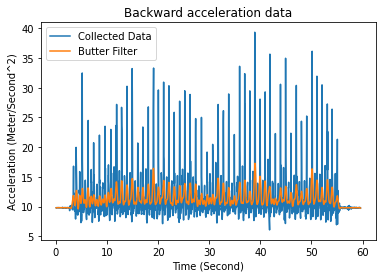

In [13]:
#backward
backward['Filtered'] = signal.filtfilt(b, a, backward['Acceleration'])
plt.plot(backward['Time'], backward['Acceleration'])
plt.plot(backward['Time'], backward['Filtered'])
plt.title('Backward acceleration data')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Collected Data', 'Butter Filter'])
plt.show()

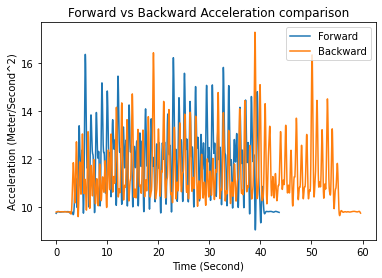

In [14]:
#forward backward graph comparison
plt.plot(forward['Time'], forward['Filtered'])
plt.plot(backward['Time'], backward['Filtered'])
plt.title('Forward vs Backward Acceleration comparison')
plt.xlabel('Time (Second)')
plt.ylabel('Acceleration (Meter/Second^2)')
plt.legend(['Forward', 'Backward'])
plt.show()
#note. we walk the same amount of distance for both, backward took longer than
#forward which wasn't suprising. Perhapes compare speed graph?

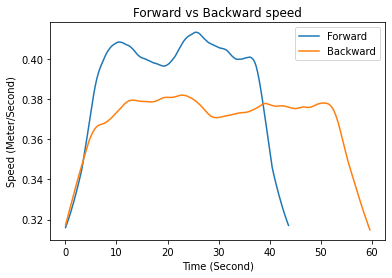

In [15]:
#Speed comparison forward and backward
#Approximate speed for both
#forward
forward['PreviousTime'] = forward['Time'].shift(1)
forward = forward.fillna(0.0)
forward['Speed'] = forward['Filtered'] * (forward['Time'] - forward['PreviousTime'])

#backward
backward['PreviousTime'] = backward['Time'].shift(1)
backward = backward.fillna(0.0)
backward['Speed'] = backward['Filtered'] * (backward['Time'] - backward['PreviousTime'])

#Forward lowess line
filtered = lowess(forward['Speed'], forward['Time'], frac=0.15)
plt.plot(filtered[:, 0], filtered[:, 1])
#Backward lowess line
filtered = lowess(backward['Speed'], backward['Time'], frac=0.15)
plt.plot(filtered[:, 0], filtered[:, 1])
plt.title('Forward vs Backward speed')
plt.legend(['Forward', 'Backward'])
plt.xlabel('Time (Second)')
plt.ylabel('Speed (Meter/Second)')
plt.show()

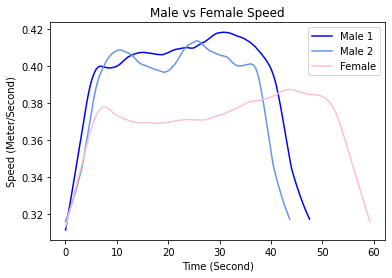

In [16]:
#plot compare speed between 2 male and 1 female
#male S
male['Filtered'] = signal.filtfilt(b, a, male['Acceleration'])
male['PreviousTime'] = male['Time'].shift(1)
male = male.fillna(0.0)
male['Speed'] = male['Filtered'] * (male['Time'] - male['PreviousTime'])
filtered = lowess(male['Speed'], male['Time'], frac=0.15)
plt.plot(filtered[:, 0], filtered[:, 1], 'blue')

#male C
filtered = lowess(forward['Speed'], forward['Time'], frac=0.15)
plt.plot(filtered[:, 0], filtered[:, 1], 'cornflowerblue')
plt.title('Male vs Female Speed')

plt.xlabel('Time (Second)')
plt.ylabel('Speed (Meter/Second)')

#female D
female['Filtered'] = signal.filtfilt(b, a, female['Acceleration'])
female['PreviousTime'] = female['Time'].shift(1)
female = female.fillna(0.0)
female['Speed'] = female['Filtered'] * (female['Time'] - female['PreviousTime'])
filtered = lowess(female['Speed'], female['Time'], frac=0.15)
plt.plot(filtered[:, 0], filtered[:, 1], 'pink')
plt.legend(['Male 1', 'Male 2','Female'])
plt.show()